Importing libaries and setting out and defining the algerbraic symbols used in the analytic part of the code.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma

INITIAL_RANGE_PARAMETER = 0.01 # In [fm^-2]
BETA = 0.0000001 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 12 # Determines the number of gaussians we expand our wave function to
XVALS = 300 # number of x values to plot in our plot of u(r)

V_LS = - 21.0 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

ORBITAL_QUANTUM_NUMBER = 0

#MIXING_COEFFICIENTS = [1.93477119e-02, -9.74485077e+00,  2.72273487e+01 , -3.93472427e+01, 4.24229294e+01 , -1.55232391e+01,
                       #-1.25564596e+01, 5.78590821e+00, 4.86431437e-01, 1.42380240e+00, 2.70790387e-02, 7.61706858e-01]
POTENTIAL_PARAMETERS = [3.06878426e+00, 1.30861947e+00, 1.17887887e+00, 9.82036493e-01, 7.79434337e-01, 6.24047341e-01, 6.24106726e-01,
                        5.38798061e-01, 1.52231002e-01, 2.54208393e-01, 8.88479703e-02, 2.54192920e-01]

MIXING_COEFFICIENTS = [0.00221229,0.00130647,-0.0109408,0.037536,-0.0872926,0.208175,-0.496584,1.26881,-2.68852,2.56339,0.186178,0.00210103]


We now want to start defining our key functions that describe relevent parts of the system

In [47]:
def generate_betas(num_gaussians, r_1=0.1, a=1.4):
    betas = np.zeros(num_gaussians)

    for i in range(num_gaussians):
        r_n = r_1 * a**i
        betas[i] = 1/(r_n**2)
        
    return betas
    
def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    expression evaluated at r, array like 
    """
    return c * np.exp(-β * (r)**2)


def gaussian_expanded_potential(radius, mixing_coefficients=MIXING_COEFFICIENTS, potential_parameters=POTENTIAL_PARAMETERS):
    potential = 0
    for i in range(len(MIXING_COEFFICIENTS)):
        potential += single_gaussian_potential_function(radius, mixing_coefficients[i], potential_parameters[i])
    return potential


def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    return radius**(orb_ang_momentum) * np.exp(-range_parameter * radius**2)

def complete_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.39 * (-1)**orb_ang_moment - 51.13 # Defines V_0 for odd and even l states
    R_0 = r_0 * num_core_nucleons**(1/3)
    centeral_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)


    return centeral_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

We have used mathmatica to get a set of analytical expressions for our matrix elements, defined here

In [48]:
def overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return (2**(0.5 + orb_ang_momentum)) * ((range_param_i * range_param_j)**(0.25 * (1 + 2 * orb_ang_momentum))) * ((
        range_param_i + range_param_j)**(-0.5 - orb_ang_momentum))
    
    # return 0.5 * (range_param_i + range_param_j)**(-0.5 - orb_ang_momentum) * gamma(0.5 + orb_ang_momentum)

def potential_matrix_element(orb_ang_momentum, range_param_i, range_param_j, potential_mixing_coefficient, potential_param):
    return 2**(0.5 + orb_ang_momentum) * potential_mixing_coefficient * (range_param_i * range_param_j)**(
        0.25 * (1 + 2 * orb_ang_momentum)) * (range_param_i + range_param_j + potential_param)**(-0.5 - orb_ang_momentum)

#    return 0.5 * potential_mixing_coefficient *  (range_param_i + range_param_j + potential_param)**(
#        -0.5 - orb_ang_momentum) * gamma(0.5 + orb_ang_momentum)

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    # differential_term = -1 * (2**(1.5 + orb_ang_momentum) * (range_param_i * range_param_j)**(0.25 * (
    #    1 + 2 * orb_ang_momentum)) * (range_param_i + range_param_j)**(-1.5 - orb_ang_momentum) * (
    #    orb_ang_momentum**2 * (range_param_i - range_param_j)**2 + (
    #       range_param_i * range_param_j) - orb_ang_momentum * (range_param_i + range_param_j)**2)
    #                    ) / (2 * orb_ang_momentum - 1)

    differential_term_1 = 2**(1.5 + orb_ang_momentum)
    differential_term_2 = (range_param_i * range_param_j)**(0.25 * (1 + 2 * orb_ang_momentum))
    differential_term_3 = (1 / (range_param_i + range_param_j))**(1.5 + orb_ang_momentum)
    differential_term_4 = orb_ang_momentum**2 * (range_param_i - range_param_j)**2 + (
    range_param_i * range_param_j) - orb_ang_momentum * (range_param_i + range_param_j)**2
    differential_term_5 = 1 / (2 * orb_ang_momentum - 1)
    total_differential_term = -1 * differential_term_1 * differential_term_2 * differential_term_3 * differential_term_4 * differential_term_5
    print(differential_term_1, differential_term_2, differential_term_3, differential_term_4, differential_term_5)

    centrifugal_term = (2**(1.5 + orb_ang_momentum) * orb_ang_momentum * (orb_ang_momentum + 1) * (
    range_param_i * range_param_j)**(0.25 * (1 + 2 * orb_ang_momentum)) * (range_param_i + range_param_j)**(
    0.5 - orb_ang_momentum)) / (2 * orb_ang_momentum - 1)
    # print(range_param_i, range_param_j, differential_term)
    print((197**2 / (2 * μ)) * total_differential_term)
    return (197**2 / (2 * μ)) * (total_differential_term + centrifugal_term)

    
#    differential_term = -0.5 * (range_param_i + range_param_j)**(-1.5 - orb_ang_momentum) * (
#        orb_ang_momentum**2 * (range_param_i - range_param_j)**2 + range_param_i * range_param_j
#        - orb_ang_momentum * (range_param_i + range_param_j)**2) * gamma(-0.5 + orb_ang_momentum)

#    centrifugal_term = -1 * 0.5 * (orb_ang_momentum * (orb_ang_momentum + 1)) * (range_param_i + range_param_j)**(
#        0.5 - orb_ang_momentum) * gamma(-0.5 + orb_ang_momentum)

#    return (197 / (2 * μ)) * differential_term * centrifugal_term

Using these we can now generate our matricies to be solved, taking care to iterate over all of our potential gaussians.

In [49]:
def matrix_generation(orb_ang_momentum, potential_mixing_coefficients=MIXING_COEFFICIENTS,
                      potential_parameters=POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))
    i = 0 # these count the elements of the matricies created
    j = 0

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            print(i_range_parameter, j_range_parameter, kinetic_energy_term)
            potential_energy_term = 0
            for k in range(len(MIXING_COEFFICIENTS)):
                potential_energy_term += potential_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter,
                                                                 potential_mixing_coefficients[k],
                                                                 potential_parameters[k])
            # potential_energy_term = 0
            # potential_energy_term = potential_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter, -40, 0.2)
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1
        # i += 1
        # print('row', i, 'column', j, 'complete')
        # j = i
    # print(h_matrix)
    # print(n_matrix)

    return h_matrix, n_matrix


def next_range_parameter(i, initial_range_parameter=INITIAL_RANGE_PARAMETER, geometric_progression_number=2):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    new_range_parameter = initial_range_parameter * geometric_progression_number**(i)
    return new_range_parameter

# def range_parameter(i, first=0.49, last=4, n=SUM_LIMIT):
#     """
#     Finds the next range parameter given the previous and initial range parameters.
#     Currently using a simple geometric series to determine range parameters.
#     Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

#     Parameters
#     ----------
#     i : int detailing the iteration number

#     Returns
#     -------
#     new_range_parameter: float

#     """
#     range_parameter = first * np.exp(np.log(last/first)*((i-1)/(n-1)))
#     return range_parameter

We now generate and then save the matrices to csv files to save having to use the computation time to rerun them every time we restart the code.

In [50]:
h_matrix, n_matrix = matrix_generation(ORBITAL_QUANTUM_NUMBER)
# print(h_matrix)
# print(n_matrix)
#np.savetxt('s_state_h_matrix.csv', h_matrix, delimiter=',')
#np.savetxt('s_state_n_matrix.csv', n_matrix, delimiter=',')

2.8284271247461903 0.1 353.5533905932738 0.0001 -1.0
0.22828823529411774
0.01 0.01 0.22828823529411774
2.8284271247461903 0.11892071150027211 192.4500897298753 0.0002 -1.0
0.2955521595010121
0.01 0.02 0.2955521595010121
2.8284271247461903 0.1414213562373095 89.44271909999159 0.0004 -1.0
0.3266995280519128
0.01 0.04 0.3266995280519128
2.8284271247461903 0.16817928305074292 37.03703703703704 0.0008 -1.0
0.32175643695784306
0.01 0.08 0.32175643695784306
2.8284271247461903 0.2 14.266801472725467 0.0016 -1.0
0.2947848233985606
0.01 0.16 0.2947848233985606
2.8284271247461903 0.23784142300054423 5.275080483505995 0.0032 -1.0
0.2592358661934888
0.01 0.32 0.2592358661934888
2.8284271247461903 0.282842712474619 1.908226685987822 0.0064 -1.0
0.2230403597748748
0.01 0.64 0.2230403597748748
2.8284271247461903 0.33635856610148585 0.6825200824229641 0.0128 -1.0
0.18973891860991457
0.01 1.28 0.18973891860991457
2.8284271247461903 0.4 0.24271706675167523 0.0256 -1.0
0.1604829119855485
0.01 2.56 0.16048


With our matrices found we now calculate the eigenvalues and the groundstate eigenvector, corresponding to the lowest (hence groundstate) energy.

In [51]:
eigenvalues, eigenvectors = scipy.linalg.eigh(h_matrix, n_matrix)
overlap_eigenvalues, overlap_eigenvectors = scipy.linalg.eigh(n_matrix)
overlap_matrix_condition_number = np.max(overlap_eigenvalues) / np.min(overlap_eigenvalues)
print(f"The overlap matrix condition number is", overlap_matrix_condition_number)

ground_state_eigenvector = np.asmatrix(eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(eigenvectors[:, 1])
print("The eigenvalues are", eigenvalues)
print("The groundstate eigenvector is", ground_state_eigenvector)

The overlap matrix condition number is 739930.1915037913
The eigenvalues are [1.40799134e-01 1.32538951e+00 4.24390278e+00 1.02623213e+01
 2.23775258e+01 4.68065143e+01 9.59730134e+01 1.95026761e+02
 3.95727657e+02 8.08271027e+02 1.68564102e+03 3.73646057e+03]
The groundstate eigenvector is [[ 3.27832512e+00 -4.29950450e+00  3.27495375e+00 -1.98349730e+00
   1.05771015e+00 -5.67139093e-01  2.74592434e-01 -1.30062759e-01
   5.79869896e-02 -2.30103231e-02  7.16676554e-03 -1.27095387e-03]]


a

In [52]:
normalisation_check = ground_state_eigenvector * n_matrix * np.transpose(ground_state_eigenvector)
print("normalisation = ", normalisation_check[0, 0])

normalisation =  1.0000000000000018


With our normalised groundstate eigenvector we have the coeffffficients of our expansion terms. With these we get our terms in the expasion of u(r) as a set of gaussians (solved numerically rather than as an sympy expression)

In [53]:
def reduced_radial_wavefunction(x_values, wavefunction_eigenvector, orbital_quantum_number=ORBITAL_QUANTUM_NUMBER, sum_limit=SUM_LIMIT, xvals = XVALS):
    """
    Defines a numerical method of finding the reduced radial wavefunction as a sum of our gaussians.
    """
    range_parameter_array = np.zeros(shape=(1, sum_limit))
    for i in range(sum_limit):
        range_parameter_array[0, i] = next_range_parameter(i)

    wavefunction_vals = np.zeros(shape=(1, xvals))
    for i in range(xvals):
        for j in range(sum_limit):
            wavefunction_vals[0, i] += wavefunction_eigenvector[0, j] * gaussian_wavefunction(x_values[i], 
                range_parameter_array[0, j], orbital_quantum_number)
    return wavefunction_vals[0, :]

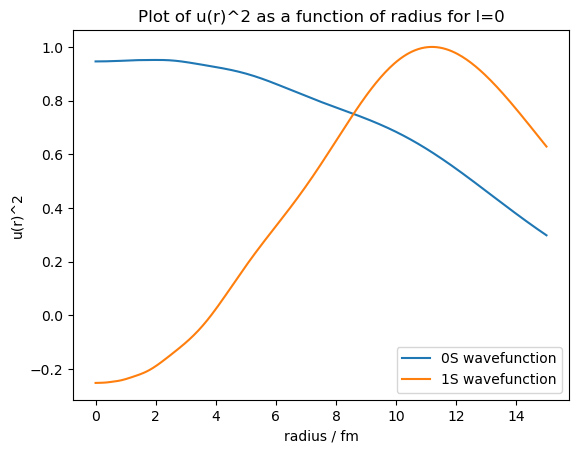

In [54]:
fig = plt.figure()
ax = fig.add_subplot()

x_values = np.linspace(0., 15, XVALS)
evaluated_ur_values = reduced_radial_wavefunction(x_values, ground_state_eigenvector, 0)[0]
#print(reduced_radial_wavefunction(x_values))

ax.set_title('Plot of u(r)^2 as a function of radius for l={}'.format(ORBITAL_QUANTUM_NUMBER))
ax.set_xlabel('radius / fm')
ax.set_ylabel('u(r)^2')
#ax.plot(x_values, evaluated_ur_values)\n
ax.plot(x_values, reduced_radial_wavefunction(x_values, ground_state_eigenvector, ORBITAL_QUANTUM_NUMBER), label="0S wavefunction")
ax.plot(x_values, reduced_radial_wavefunction(x_values, s1_eigenvector, ORBITAL_QUANTUM_NUMBER), label="1S wavefunction")
ax.legend()

plt.savefig('s_state_plot.png', dpi=300)
plt.show()

i


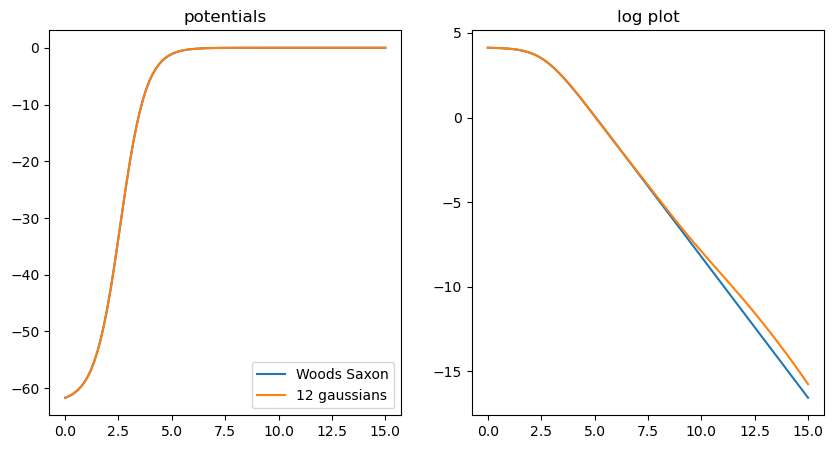

In [55]:
fig = plt.figure(figsize = (10,5))
X_vals = np.linspace(0.0000000000001, 15, 100)

def single_gaussian_potential_function_plot(radius, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : sympy variable
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    sympy expression
    """
    return c * np.exp(-β * (radius)**2)

def gaussian_potential_plot(radius, l, mixing_coefficients=MIXING_COEFFICIENTS, potential_parameters=POTENTIAL_PARAMETERS):
    """
    Defines the spherically symmetric gaussian potential as a function of radius we use as a 'first guess'
    to make our integrals analytic. Given as V = V_0 * e**(-beta * radius**2)

    Parameters
    ----------
    radius : float
    parameters : 1d array containg the fixed parameters for our potential. In the order [V_0, beta] (see slides/supplimentary notes) 

    Returns
    -------
    float with the value of the potential at a radius r

    """
    V_0 = -11.39 * (-1)**l - 51.13 # Defines V_0 for odd and even l states
    betas = generate_betas(12)
    return V_0 * (single_gaussian_potential_function_plot(radius, mixing_coefficients[0], betas[0])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[1], betas[1]) 
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[2], betas[2])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[3], betas[3])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[4], betas[4])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[5], betas[5])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[6], betas[6])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[7], betas[7])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[8], betas[8])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[9], betas[9])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[10], betas[10])
            + single_gaussian_potential_function_plot(radius, mixing_coefficients[11], betas[11])
        
    )

spec = fig.add_gridspec(ncols=2, nrows=1)
ax_1 = fig.add_subplot(spec[0, 0])
ax_2 = fig.add_subplot(spec[0, 1])

ax_1.plot(X_vals, complete_potential(X_vals, 0.5, 0), label = 'Woods Saxon')
ax_1.plot(X_vals, gaussian_potential_plot(X_vals, 0), label = '12 gaussians')
ax_1.legend()
ax_1.set_title('potentials')
print('i')

ax_2.plot(X_vals, np.log(-complete_potential(X_vals, 0.5, 0)), label = '12 gaussians')
ax_2.plot(X_vals, np.log(-gaussian_potential_plot(X_vals, 0)), label = '12 gaussians')
ax_2.set_title('log plot')

plt.show()